 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="http://localhost:8888/notebooks/barebone-yolo.ipynb#YOLO" data-toc-modified-id="YOLO-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>YOLO</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/barebone-yolo.ipynb#Import-packages" data-toc-modified-id="Import-packages-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import packages</a></span></li><li><span><a href="http://localhost:8888/notebooks/barebone-yolo.ipynb#Define-and-initialize-global-variables" data-toc-modified-id="Define-and-initialize-global-variables-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Define and initialize global variables</a></span></li><li><span><a href="http://localhost:8888/notebooks/barebone-yolo.ipynb#Construct-the-Network" data-toc-modified-id="Construct-the-Network-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Construct the Network</a></span></li><li><span><a href="http://localhost:8888/notebooks/barebone-yolo.ipynb#Load-Pretrained-weights" data-toc-modified-id="Load-Pretrained-weights-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Load Pretrained weights</a></span></li><li><span><a href="http://localhost:8888/notebooks/barebone-yolo.ipynb#Randomize-weights-of-the-last-layer" data-toc-modified-id="Randomize-weights-of-the-last-layer-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Randomize weights of the last layer</a></span></li><li><span><a href="http://localhost:8888/notebooks/barebone-yolo.ipynb#Training" data-toc-modified-id="Training-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Training</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/barebone-yolo.ipynb#Loss-Function" data-toc-modified-id="Loss-Function-1.6.1"><span class="toc-item-num">1.6.1&nbsp;&nbsp;</span>Loss Function</a></span></li><li><span><a href="http://localhost:8888/notebooks/barebone-yolo.ipynb#Parse-the-annotations-to-construct-train-generator-and-validation-generator" data-toc-modified-id="Parse-the-annotations-to-construct-train-generator-and-validation-generator-1.6.2"><span class="toc-item-num">1.6.2&nbsp;&nbsp;</span>Parse the annotations to construct train generator and validation generator</a></span></li></ul></li><li><span><a href="http://localhost:8888/notebooks/barebone-yolo.ipynb#Setup-a-few-callbacks-and-start-the-training" data-toc-modified-id="Setup-a-few-callbacks-and-start-the-training-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Setup a few callbacks and start the training</a></span></li></ul></li></ul></div>

# YOLO

## Import packages

In [1]:
from keras import models
from keras import layers
from keras import callbacks
from keras import optimizers
from keras.utils.vis_utils import plot_model
import keras.backend as K
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('seaborn')
import numpy as np
import os
import cv2
import imgaug as ia
from imgaug import augmenters as iaa
from preprocessing import parse_annotation, BatchGenerator
from utils import WeightReader, decode_netout, draw_boxes

/home/savath/.virtualenvs/keras_tf/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Define and initialize global variables

In [2]:
LABELS = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

IMAGE_H, IMAGE_W = 416, 416
GRID_H,  GRID_W  = 13 , 13
BOX              = 5
CLASS            = len(LABELS)
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')
OBJ_THRESHOLD    = 0.3#0.5
NMS_THRESHOLD    = 0.3#0.45
ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]

NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0

BATCH_SIZE       = 16
WARM_UP_BATCHES  = 0
TRUE_BOX_BUFFER  = 50


ALPHA = 0.1

In [3]:
pre_trained_weights='/media/savath/Data/SovannDeep/weight-yolo/yolo.weights'
train_image_folder = '/media/savath/Data/SovannDeep/deepdata/coco/images/train2014/'
train_annot_folder = '/media/savath/Data/SovannDeep/deepdata/coco/train2014ann/'
val_image_folder = '/media/savath/Data/SovannDeep/deepdata/coco/images/val2014/'
val_annot_folder = '/media/savath/Data/SovannDeep/deepdata/coco/val2014ann/'

## Construct the Network

In [4]:
# the function to implement the orgnization layer (thanks to github.com/allanzelener/YAD2K)
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

In [5]:
input_image = layers.Input(shape=(IMAGE_H, IMAGE_W, 3))
true_boxes  = layers.Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4))

In [6]:
def yolo():
    
 
    # Layer 1
    x = layers.Conv2D(32, (3, 3), strides=(1, 1), 
                        padding='same', name='conv_1', use_bias=False)(input_image)
    x = layers.BatchNormalization(name='norm_1')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    x = layers.MaxPool2D(pool_size=(2,2))(x)
    
    # Layer 2
    x = layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', name='conv_2', use_bias=False)(x)
    x = layers.BatchNormalization(name='norm_2')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    
    # Layer 3
    x = layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same', name='conv_3', use_bias=False)(x)
    x = layers.BatchNormalization(name='norm_3')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    
    # Layer 4 
    x = layers.Conv2D(64, (1, 1), strides=(1, 1), padding='same', name='conv_4', use_bias=False)(x)
    x = layers.BatchNormalization(name='norm_4')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    
    # Layer 5
    x = layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same', name='conv_5', use_bias=False)(x)
    x = layers.BatchNormalization(name='norm_5')(x)
    x= layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    # Layer 6
    x = layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same', name='conv_6', use_bias=False)(x)
    x = layers.BatchNormalization(name='norm_6')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    
    
    # Layer 7
    x = layers.Conv2D(128, (1, 1), strides=(1, 1), padding='same', name='conv_7', use_bias=False)(x)
    x= layers.BatchNormalization(name='norm_7')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    
    # Layer 8
    x = layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same', name='conv_8', use_bias=False)(x)
    x = layers.BatchNormalization(name='norm_8')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    # Layer 9
    x = layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same', name='conv_9', use_bias=False)(x)
    x = layers.BatchNormalization(name='norm_9')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    
    # Layer 10
    x = layers.Conv2D(256, (1, 1), strides=(1, 1), padding='same', name='conv_10', use_bias=False)(x)
    x = layers.BatchNormalization(name='norm_10')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    
    # Layer 11
    x = layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same', name='conv_11', use_bias=False)(x)
    x = layers.BatchNormalization(name='norm_11')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    
    
    # Layer 12
    x = layers.Conv2D(256, (1, 1), strides=(1, 1), padding='same', name='conv_12', use_bias=False)(x)
    x = layers.BatchNormalization(name='norm_12')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    
    # Layer 13
    x = layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same', name='conv_13', use_bias=False)(x)
    x = layers.BatchNormalization(name='norm_13')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    
    
    skip_connection = x
    
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    
    # Layer 14
    x = layers.Conv2D(1024, (3, 3), strides=(1, 1), padding='same', name='conv_14', use_bias=False)(x)
    x = layers.BatchNormalization(name='norm_14')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    
    # Layer 15
    x = layers.Conv2D(512, (1, 1), strides=(1, 1), padding='same', name='conv_15', use_bias=False)(x)
    x = layers.BatchNormalization(name='norm_15')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    
    # Layer 16
    x = layers.Conv2D(1024, (3, 3), strides=(1, 1), padding='same', name='conv_16', use_bias=False)(x)
    x = layers.BatchNormalization(name='norm_16')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    
    # Layer 17
    x = layers.Conv2D(512, (1, 1), strides=(1, 1), padding='same', name='conv_17', use_bias=False)(x)
    x = layers.BatchNormalization(name='norm_17')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    
    # Layer 18
    x = layers.Conv2D(1024, (3, 3), strides=(1, 1), padding='same', name='conv_18', use_bias=False)(x)
    x = layers.BatchNormalization(name='norm_18')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    
    # Layer 19
    x = layers.Conv2D(1024, (3, 3), strides=(1, 1), padding='same', name='conv_19', use_bias=False)(x)
    x = layers.BatchNormalization(name='norm_19')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    
    # Layer 20
    x = layers.Conv2D(1024, (3, 3), strides=(1, 1), padding='same', name='conv_20', use_bias=False)(x)
    x = layers.BatchNormalization(name='norm_20')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    
    
    # Layer 21
    skip_connection = layers.Conv2D(64, (1, 1), strides=(1, 1), 
                                padding='same', name='conv_21', use_bias=False)(skip_connection)
    skip_connection = layers.BatchNormalization(name='norm_21')(skip_connection)
    skip_connection = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(skip_connection)
    skip_connection = layers.Lambda(space_to_depth_x2)(skip_connection)
    
    x = layers.concatenate([skip_connection, x])
    
    # Layer 22
    x = layers.Conv2D(1024, (3, 3), strides=(1, 1), padding='same', name='conv_22',
                     use_bias=False)(x)
    x = layers.BatchNormalization(name='norm_22')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    
    # Layer 23
    x = layers.Conv2D((4 + 1 + CLASS) * 5, (1,1), strides=(1,1), padding='same', name='conv_23')(x)
    output = layers.Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS))(x)
    
    # small hack to allow true_boxes to be registered when Keras build the model 
    # for more information: https://github.com/fchollet/keras/issues/2790
    output = layers.Lambda(lambda args: args[0])([output, true_boxes])
    
    model = models.Model([input_image, true_boxes], output)
                                    
    
    return model


In [7]:
model = yolo()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 416, 416, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 416, 416, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 416, 416, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 416, 416, 32) 0           norm_1[0][0]                     
__________________________________________________________________________________________________
max_poolin

In [8]:
plot_model(model, to_file='model1.png')

Total params: 50,983,561
Trainable params: 50,962,889
Non-trainable params: 20,672

## Load Pretrained weights

Load the weights originally provided by YOLO

In [8]:
weight_reader = WeightReader(pre_trained_weights)

In [9]:
weight_reader.reset()
nb_conv = 23

In [10]:
for i in range(1, nb_conv+1):
    conv_layer = model.get_layer('conv_' + str(i))
    
    if i < nb_conv:
        norm_layer = model.get_layer('norm_' + str(i))
        
        size = np.prod(norm_layer.get_weights()[0].shape)
        
        beta = weight_reader.read_bytes(size)
        gamma = weight_reader.read_bytes(size)
        mean = weight_reader.read_bytes(size)
        var = weight_reader.read_bytes(size)
        
        weights = norm_layer.set_weights([gamma, beta, mean, var])
        
    if len(conv_layer.get_weights()) > 1:
        bias = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel, bias])
        
    else:
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel])

## Randomize weights of the last layer

In [11]:
# Get last convolutional layer
layer = model.layers[-4] 
weights = layer.get_weights()

new_kernel = np.random.normal(size=weights[0].shape) / (GRID_H*GRID_W)
new_bias   = np.random.normal(size=weights[1].shape) / (GRID_H*GRID_W)

layer.set_weights([new_kernel, new_bias])

## Training

### Loss Function

![](images/custom-loss.png)

![](images/custom-loss2.png)


In [12]:
def custom_loss(y_true, y_pred):
    mask_shape = tf.shape(y_true)[:4]
    
    cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)))
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))

    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, 5, 1])
    
    coord_mask = tf.zeros(mask_shape)
    conf_mask  = tf.zeros(mask_shape)
    class_mask = tf.zeros(mask_shape)
    
    seen = tf.Variable(0.)
    
    total_AP = tf.Variable(0.)
    
    """
    Adjust prediction
    """
    ### adjust x and y      
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid
    
    ### adjust w and h
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])
    
    ### adjust confidence
    pred_box_conf = tf.sigmoid(y_pred[..., 4])
    
    ### adjust class probabilities
    pred_box_class = y_pred[..., 5:]
    
    """
    Adjust ground truth
    """
    ### adjust x and y
    true_box_xy = y_true[..., 0:2] # relative position to the containing cell
    
    ### adjust w and h
    true_box_wh = y_true[..., 2:4] # number of cells accross, horizontally and vertically
    
    ### adjust confidence
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half
    
    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half       
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    
    true_box_conf = iou_scores * y_true[..., 4]
    
    ### adjust class probabilities
    true_box_class = tf.to_int32(y_true[..., 5])
    
    """
    Determine the masks
    """
    ### coordinate mask: simply the position of the ground truth boxes (the predictors)
    coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * COORD_SCALE
    
    ### confidence mask: penelize predictors + penalize boxes with low IOU
    # penalize the confidence of the boxes, which have IOU with some ground truth box < 0.6
    true_xy = true_boxes[..., 0:2]
    true_wh = true_boxes[..., 2:4]
    
    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    
    pred_xy = tf.expand_dims(pred_box_xy, 4)
    pred_wh = tf.expand_dims(pred_box_wh, 4)
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)

    best_ious = tf.reduce_max(iou_scores, axis=4)
    conf_mask = conf_mask + tf.to_float(best_ious < 0.6) * (1 - y_true[..., 4]) * NO_OBJECT_SCALE
    
    # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
    conf_mask = conf_mask + y_true[..., 4] * OBJECT_SCALE
    
    ### class mask: simply the position of the ground truth boxes (the predictors)
    class_mask = y_true[..., 4] * tf.gather(CLASS_WEIGHTS, true_box_class) * CLASS_SCALE       
    
    """
    Warm-up training
    """
    no_boxes_mask = tf.to_float(coord_mask < COORD_SCALE/2.)
    seen = tf.assign_add(seen, 1.)
    
    true_box_xy, true_box_wh, coord_mask = tf.cond(tf.less(seen, WARM_UP_BATCHES), 
                          lambda: [true_box_xy + (0.5 + cell_grid) * no_boxes_mask, 
                                   true_box_wh + tf.ones_like(true_box_wh) * np.reshape(ANCHORS, [1,1,1,BOX,2]) * no_boxes_mask, 
                                   tf.ones_like(coord_mask)],
                          lambda: [true_box_xy, 
                                   true_box_wh,
                                   coord_mask])
    
    """
    Finalize the loss
    """
    nb_coord_box = tf.reduce_sum(tf.to_float(coord_mask > 0.0))
    nb_conf_box  = tf.reduce_sum(tf.to_float(conf_mask  > 0.0))
    nb_class_box = tf.reduce_sum(tf.to_float(class_mask > 0.0))
    
    loss_xy    = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh    = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_conf  = tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)
    
    loss = loss_xy + loss_wh + loss_conf + loss_class
    
    nb_true_box = tf.reduce_sum(y_true[..., 4])
    nb_pred_box = tf.reduce_sum(tf.to_float(true_box_conf > 0.5) * tf.to_float(pred_box_conf > OBJ_THRESHOLD))
    
    total_AP = tf.assign_add(total_AP, nb_pred_box/nb_true_box) 
    
    loss = tf.Print(loss, [loss_xy, loss_wh, loss_conf, loss_class, loss, total_AP/seen], message='DEBUG', summarize=1000)
    
    return loss



### Parse the annotations to construct train generator and validation generator

In [13]:
generator_config = {
    'IMAGE_H'         : IMAGE_H, 
    'IMAGE_W'         : IMAGE_W,
    'GRID_H'          : GRID_H,  
    'GRID_W'          : GRID_W,
    'BOX'             : BOX,
    'LABELS'          : LABELS,
    'CLASS'           : len(LABELS),
    'ANCHORS'         : ANCHORS,
    'BATCH_SIZE'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : 50,
}



In [15]:
%%time
train_imgs, seen_train_labels = parse_annotation(train_annot_folder, train_image_folder, labels=LABELS)

CPU times: user 23.8 s, sys: 7.46 s, total: 31.2 s
Wall time: 16min 42s


In [14]:
import os
import cv2
import copy
import numpy as np
import imgaug as ia
from imgaug import augmenters as iaa
import xml.etree.ElementTree as ET
from utils import BoundBox, normalize, bbox_iou

In [15]:
class BatchGenerator:
    def __init__(self, images, 
                       config, 
                       shuffle=True, 
                       jitter=True, 
                       norm=True):

        self.images = images
        self.config = config

        self.shuffle = shuffle
        self.jitter  = jitter
        self.norm    = norm
        

        self.anchors = [BoundBox(0, 0, config['ANCHORS'][2*i], config['ANCHORS'][2*i+1]) for i in range(int(len(config['ANCHORS'])/2))]

        ### augmentors by https://github.com/aleju/imgaug
        sometimes = lambda aug: iaa.Sometimes(0.5, aug)

        # Define our sequence of augmentation steps that will be applied to every image
        # All augmenters with per_channel=0.5 will sample one value _per image_
        # in 50% of all cases. In all other cases they will sample new values
        # _per channel_.
        self.aug_pipe = iaa.Sequential(
            [
                # apply the following augmenters to most images
                #iaa.Fliplr(0.5), # horizontally flip 50% of all images
                #iaa.Flipud(0.2), # vertically flip 20% of all images
                #sometimes(iaa.Crop(percent=(0, 0.1))), # crop images by 0-10% of their height/width
                sometimes(iaa.Affine(
                    #scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
                    #translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
                    #rotate=(-5, 5), # rotate by -45 to +45 degrees
                    #shear=(-5, 5), # shear by -16 to +16 degrees
                    #order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
                    #cval=(0, 255), # if mode is constant, use a cval between 0 and 255
                    #mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
                )),
                # execute 0 to 5 of the following (less important) augmenters per image
                # don't execute all of them, as that would often be way too strong
                iaa.SomeOf((0, 5),
                    [
                        #sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                        iaa.OneOf([
                            iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                            iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                            iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                        ]),
                        iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                        #iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                        # search either for all edges or for directed edges
                        #sometimes(iaa.OneOf([
                        #    iaa.EdgeDetect(alpha=(0, 0.7)),
                        #    iaa.DirectedEdgeDetect(alpha=(0, 0.7), direction=(0.0, 1.0)),
                        #])),
                        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                        iaa.OneOf([
                            iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                            #iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                        ]),
                        #iaa.Invert(0.05, per_channel=True), # invert color channels
                        iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                        iaa.Multiply((0.5, 1.5), per_channel=0.5), # change brightness of images (50-150% of original value)
                        iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
                        #iaa.Grayscale(alpha=(0.0, 1.0)),
                        #sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                        #sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))) # sometimes move parts of the image around
                    ],
                    random_order=True
                )
            ],
            random_order=True
        )

        if shuffle: np.random.shuffle(self.images)

    def get_generator(self):
        num_img = len(self.images)
        
        total_count = 0
        batch_count = 0
        
        x_batch = np.zeros((self.config['BATCH_SIZE'], self.config['IMAGE_H'], self.config['IMAGE_W'], 3))                         # input images
        b_batch = np.zeros((self.config['BATCH_SIZE'], 1     , 1     , 1    ,  self.config['TRUE_BOX_BUFFER'], 4))   # list of self.config['TRUE_self.config['BOX']_BUFFER'] GT boxes
        y_batch = np.zeros((self.config['BATCH_SIZE'], self.config['GRID_H'],  self.config['GRID_W'], self.config['BOX'], 4+1+1))                # desired network output
        
        while True:
            if total_count < num_img:
                train_instance = self.images[total_count]

                # augment input image and fix object's position and size
                img, all_objs = self.aug_image(train_instance, jitter=self.jitter)
                
                # construct output from object's x, y, w, h
                true_box_index = 0
                
                for obj in all_objs:
                    if obj['xmax'] > obj['xmin'] and obj['ymax'] > obj['ymin'] and obj['name'] in self.config['LABELS']:
                        center_x = .5*(obj['xmin'] + obj['xmax'])
                        center_x = center_x / (float(self.config['IMAGE_W']) / self.config['GRID_W'])
                        center_y = .5*(obj['ymin'] + obj['ymax'])
                        center_y = center_y / (float(self.config['IMAGE_H']) / self.config['GRID_H'])

                        grid_x = int(np.floor(center_x))
                        grid_y = int(np.floor(center_y))

                        if grid_x < self.config['GRID_W'] and grid_y < self.config['GRID_H']:
                            obj_indx  = self.config['LABELS'].index(obj['name'])
                            
                            center_w = (obj['xmax'] - obj['xmin']) / (float(self.config['IMAGE_W']) / self.config['GRID_W']) # unit: grid cell
                            center_h = (obj['ymax'] - obj['ymin']) / (float(self.config['IMAGE_W']) / self.config['GRID_W']) # unit: grid cell
                            
                            box = [center_x, center_y, center_w, center_h]

                            # find the anchor that best predicts this box
                            best_anchor = -1
                            max_iou     = -1
                            
                            shifted_box = BoundBox(0, 
                                                   0, 
                                                   center_w, 
                                                   center_h)
                            
                            for i in range(len(self.anchors)):
                                anchor = self.anchors[i]
                                iou    = bbox_iou(shifted_box, anchor)
                                
                                if max_iou < iou:
                                    best_anchor = i
                                    max_iou     = iou
                                    
                            # assign ground truth x, y, w, h, confidence and class probs to y_batch
                            y_batch[batch_count, grid_y, grid_x, best_anchor, 0:4]        = box
                            y_batch[batch_count, grid_y, grid_x, best_anchor, 4  ]        = 1.
                            y_batch[batch_count, grid_y, grid_x, best_anchor, 5  ]        = obj_indx
                            
                            # assign the true box to b_batch
                            b_batch[batch_count, 0, 0, 0, true_box_index] = box
                            
                            true_box_index += 1
                            true_box_index = true_box_index % self.config['TRUE_BOX_BUFFER']
                                
                # assign input image to x_batch
                if self.norm: 
                    x_batch[batch_count] = normalize(img)
                else:
                    # plot image and bounding boxes for sanity check
                    for obj in all_objs:
                        if obj['xmax'] > obj['xmin'] and obj['ymax'] > obj['ymin']:
                            cv2.rectangle(img[:,:,::-1], (obj['xmin'],obj['ymin']), (obj['xmax'],obj['ymax']), (255,0,0), 3)
                            cv2.putText(img[:,:,::-1], obj['name'], 
                                        (obj['xmin']+2, obj['ymin']+12), 
                                        0, 1.2e-3 * img.shape[0], 
                                        (0,255,0), 2)
                            
                    x_batch[batch_count] = img

                # increase instance counter in current batch
                batch_count += 1  
                    
            total_count += 1
            if total_count >= num_img:
                total_count = 0
                if self.shuffle: np.random.shuffle(self.images)                    

            if batch_count >= self.config['BATCH_SIZE']:
                yield [x_batch, b_batch], y_batch
                
                x_batch = np.zeros((self.config['BATCH_SIZE'], self.config['IMAGE_H'], self.config['IMAGE_W'], 3))
                y_batch = np.zeros((self.config['BATCH_SIZE'], self.config['GRID_H'],  self.config['GRID_W'],  self.config['BOX'], 5+self.config['CLASS']))       
                
                batch_count = 0

    def aug_image(self, train_instance, jitter):
        image_name = train_instance['filename']
        image = cv2.imread(image_name)
        h, w, c = image.shape
        
        all_objs = copy.deepcopy(train_instance['object'])

        if jitter:
            ### scale the image
            scale = np.random.uniform() / 10. + 1.
            image = cv2.resize(image, (0,0), fx = scale, fy = scale)

            ### translate the image
            max_offx = (scale-1.) * w
            max_offy = (scale-1.) * h
            offx = int(np.random.uniform() * max_offx)
            offy = int(np.random.uniform() * max_offy)
            
            image = image[offy : (offy + h), offx : (offx + w)]

            ### flip the image
            flip = np.random.binomial(1, .5)
            if flip > 0.5: image = cv2.flip(image, 1)
                
            image = self.aug_pipe.augment_image(image)            
            
        # resize the image to standard size
        image = cv2.resize(image, (self.config['IMAGE_H'], self.config['IMAGE_W']))
        image = image[:,:,::-1]

        # fix object's position and size
        for obj in all_objs:
            for attr in ['xmin', 'xmax']:
                if jitter: obj[attr] = int(obj[attr] * scale - offx)
                    
                obj[attr] = int(obj[attr] * float(self.config['IMAGE_W']) / w)
                obj[attr] = max(min(obj[attr], self.config['IMAGE_W']), 0)
                
            for attr in ['ymin', 'ymax']:
                if jitter: obj[attr] = int(obj[attr] * scale - offy)
                    
                obj[attr] = int(obj[attr] * float(self.config['IMAGE_H']) / h)
                obj[attr] = max(min(obj[attr], self.config['IMAGE_H']), 0)

            if jitter and flip > 0.5:
                xmin = obj['xmin']
                obj['xmin'] = self.config['IMAGE_W'] - obj['xmax']
                obj['xmax'] = self.config['IMAGE_W'] - xmin
                
        return image, all_objs

    def get_dateset_size(self):
        return int(np.ceil(float(len(self.images))/self.config['BATCH_SIZE']))

In [18]:
%%time
train_batch = BatchGenerator(train_imgs, generator_config)

CPU times: user 9.79 ms, sys: 0 ns, total: 9.79 ms
Wall time: 9.68 ms


In [19]:
%%time
val_imgs, seen_val_labels = parse_annotation(val_annot_folder, val_image_folder, labels=LABELS)

CPU times: user 7.55 s, sys: 2.19 s, total: 9.74 s
Wall time: 3min 26s


In [20]:
%%time
valid_batch = BatchGenerator(val_imgs, generator_config, jitter=False)

CPU times: user 3.67 ms, sys: 0 ns, total: 3.67 ms
Wall time: 3.66 ms


## Setup a few callbacks and start the training

In [21]:
early_stop = callbacks.EarlyStopping(monitor='val_loss', 
                           min_delta=0.001, 
                           patience=3, 
                           mode='min', 
                           verbose=1)

checkpoint = callbacks.ModelCheckpoint('weights_coco.h5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             period=1)

In [23]:
tb_counter  = len([log for log in os.listdir(os.path.expanduser('~/logs/')) if 'coco_' in log]) + 1
tensorboard = callbacks.TensorBoard(log_dir=os.path.expanduser('~/logs/') + 'coco_' + '_' + str(tb_counter), 
                          histogram_freq=0, 
                          write_graph=True, 
                          write_images=False)

optimizer = optimizers.Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#optimizer = SGD(lr=1e-4, decay=0.0005, momentum=0.9)
#optimizer = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(loss=custom_loss, optimizer=optimizer)

model.fit_generator(generator        = train_batch.get_generator(), 
                    steps_per_epoch  = train_batch.get_dateset_size(), 
                    epochs           = 100, 
                    verbose          = 1,
                    validation_data  = valid_batch.get_generator(),
                    validation_steps = valid_batch.get_dateset_size(),
                    callbacks        = [early_stop, checkpoint, tensorboard], 
                    max_queue_size   = 3)

Epoch 1/100
5120/5120 [==============================] - 6641s 1s/step - loss: 1.6873 - val_loss: 1.0726

Epoch 00001: val_loss improved from inf to 1.07262, saving model to weights_coco.h5
Epoch 2/100
5120/5120 [==============================] - 7233s 1s/step - loss: 1.1966 - val_loss: 1.0173

Epoch 00002: val_loss improved from 1.07262 to 1.01733, saving model to weights_coco.h5
Epoch 3/100
5120/5120 [==============================] - 7248s 1s/step - loss: 1.0955 - val_loss: 0.9925

Epoch 00003: val_loss improved from 1.01733 to 0.99251, saving model to weights_coco.h5
Epoch 4/100
5120/5120 [==============================] - 7253s 1s/step - loss: 1.0352 - val_loss: 0.9970

Epoch 00004: val_loss did not improve
Epoch 5/100
5120/5120 [==============================] - 7237s 1s/step - loss: 0.9922 - val_loss: 0.9839

Epoch 00005: val_loss improved from 0.99251 to 0.98389, saving model to weights_coco.h5
Epoch 6/100
5120/5120 [==============================] - 7109s 1s/step - loss: 0.945

# Perform detection on image

In [16]:
model.load_weights("weights_coco.h5")

dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

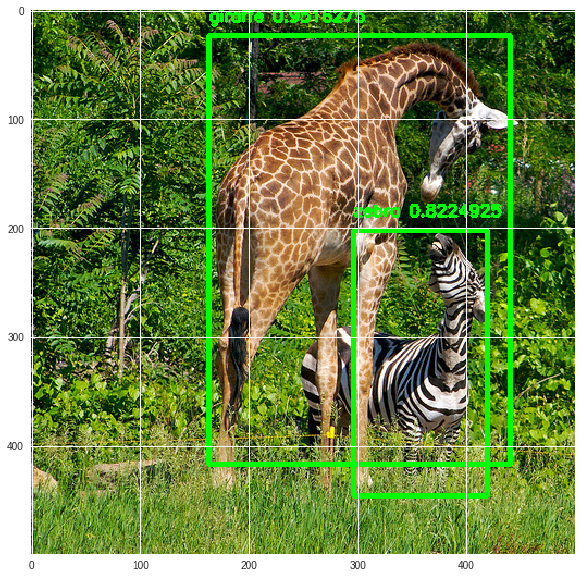

In [17]:
image = cv2.imread('/media/savath/Data/SovannDeep/keras-yolo-master/images/giraffe.jpg')
plt.figure(figsize=(10,10))

input_image = cv2.resize(image, (416, 416))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = model.predict([input_image, dummy_array])

boxes = decode_netout(netout[0], 
                      obj_threshold=OBJ_THRESHOLD,
                      nms_threshold=NMS_THRESHOLD,
                      anchors=ANCHORS, 
                      nb_class=CLASS)
image = draw_boxes(image, boxes, labels=LABELS)

plt.imshow(image[:,:,::-1]); plt.show()

# Perform detection on video

In [ ]:
model.load_weights("weights_coco.h5")

dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

In [ ]:
video_inp = '../basic-yolo-keras/images/phnom_penh.mp4'
video_out = '../basic-yolo-keras/images/phnom_penh_bbox.mp4'

video_reader = cv2.VideoCapture(video_inp)

nb_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
frame_h = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_w = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))

video_writer = cv2.VideoWriter(video_out,
                               cv2.VideoWriter_fourcc(*'XVID'), 
                               50.0, 
                               (frame_w, frame_h))

for i in tqdm(range(nb_frames)):
    ret, image = video_reader.read()
    
    input_image = cv2.resize(image, (416, 416))
    input_image = input_image / 255.
    input_image = input_image[:,:,::-1]
    input_image = np.expand_dims(input_image, 0)

    netout = model.predict([input_image, dummy_array])

    boxes = decode_netout(netout[0], 
                          obj_threshold=0.3,
                          nms_threshold=NMS_THRESHOLD,
                          anchors=ANCHORS, 
                          nb_class=CLASS)
    image = draw_boxes(image, boxes, labels=LABELS)

    video_writer.write(np.uint8(image))
    
video_reader.release()
video_writer.release()  